In [1]:
import bz2
import os
import ftplib
import tarfile
import urllib.request

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

###  千葉大学リモートセンシング研究センターから取得する衛星画像の設定 

In [2]:
date = "20220901" # 8桁の数字で入力する
time = "1700" # 協定世界時刻であることに注意。つまり，日本時間はこれよりも9時間進んでいる
band = "tir" # バンド名 vis, tir 
ch = "01" # チャンネル番号

# 最大，最小の緯度と経度，縦横の画素数
lon_min = 85
lon_max = 205
lat_min = -60
lat_max = 60
n = 6000

extent_hmwr = (lon_min, lon_max, lat_min, lat_max)

### ひまわりの画像データを読み込む
 - ひまわりデータは千葉大学リモートセンシング研究センターがFTPで提供しているものを利用する。
 - wscp '/gridded/FD/V20190123/202209/TIR'

In [8]:
server = "hmwr829gr.cr.chiba-u.ac.jp"
tail = "fld.geoss.bz2"
fname_hmwr = f"{date}{time}.{band}.{ch}.{tail}"
url = f"{server}/{date[0:6]}/{band.upper()}/{fname_hmwr}"
folder = 'data/'

In [5]:
print(fname_hmwr)

202209011700.tir.01.fld.geoss.bz2


### センサのカウント値を放射輝度へ変換する必要
そのための変換テーブルをダウンロードする

In [6]:
_, cnt2tbb = np.loadtxt(f'data/count2tbb_v103/{band}.{ch}', unpack=True)

###  標準ライブラリbz2を使用して，ひまわり画像を開く。
 - # 画像データを変換テーブルで変換する

In [9]:
with bz2.open(folder + fname_hmwr) as bz2fin:
    buf_cnt = bz2fin.read()
    data_cnt = np.frombuffer(buf_cnt, dtype = '>u2').reshape(n, n)
    
    data_tbb = cnt2tbb[data_cnt] 

### プロット

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn(

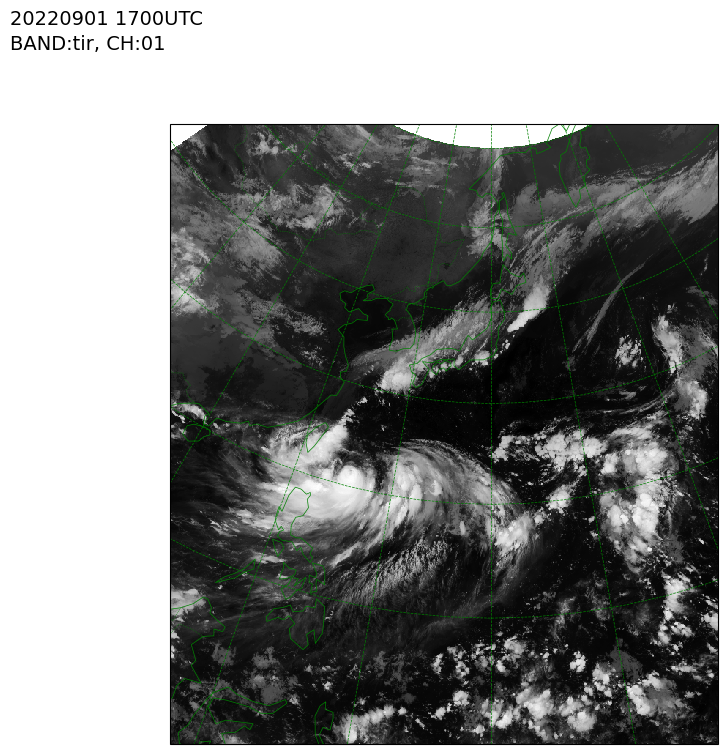

In [11]:
# mapcrs = ccrs.PlateCarree()
mapcrs = ccrs.NorthPolarStereo(central_longitude = 140.0, true_scale_latitude = 60.0) # 気象庁「日々の天気図」に近いもの
# mapcrs = ccrs.Robinson(central_longitude=180.0) # ロビンソン図法
# mapcrs = ccrs.Mercator() # メルカトル図法
# mapcrs = ccrs.Mollweide() # モルワイデ図法

out_fig_path = f'{date}{time}-himawari_{band}{ch}.png'

fig = plt.figure(figsize=(294/25.4, 210/25.4))
fig.text(0.10, 0.97, f"{date} {time}UTC", fontsize=14)
fig.text(0.10, 0.94, f"BAND:{band}, CH:{ch}", fontsize=14)

ax = fig.add_axes([0.10, 0.10, 0.75, 0.75], projection=mapcrs)

ax.add_feature(cfeature.COASTLINE, linewidth = 0.5, color = "green")
ax.add_feature(cfeature.BORDERS, linewidth = 0.5, linestyle = ':', color = "green")

ax.set_extent([117.0, 156.0, 0.0, 61.0], ccrs.PlateCarree())
# ax.set_extent([117.0, 156.0, 18.0, 61.0], ccrs.PlateCarree())
ax.imshow(data_tbb, origin='upper', extent = extent_hmwr, interpolation = 'none', cmap = "gray_r", transform = ccrs.PlateCarree())

ax.gridlines(xlocs=np.arange(100, 180, 10), 
             ylocs=np.arange(10, 90, 10),
             linestyle = 'dashed', color = 'green', linewidth = 0.5)

#------------------------------------------------------------------------------
# 図の保存
# plt.savefig(out_fig_path, transparent=False)